In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#這兩行讓 matplotlib 的圖可以顯示中文，同時正常顯示負號
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False
import datetime
from sklearn.feature_selection import r_regression as pearsonr
from copy import deepcopy
from tqdm import tqdm
import os
import joblib
import json

In [2]:
from utils import power_generation_types as power_types #各發電機組屬於哪種發電方式的定義檔
from utils.holidays import * #節假日，彈性放假與補班日

In [3]:
pd.set_option('future.no_silent_downcasting', True)

In [4]:
# 定義EDA使用資料的時間範圍
start_date = datetime.datetime.strptime('2023-01-01', '%Y-%m-%d')
end_date = datetime.datetime.strptime('2024-06-30', '%Y-%m-%d')

In [5]:
# 各站經緯度與海拔
site_location_dict = {
    '臺北': {'lat':'25.037658' ,'lon':'121.514853', 'elevation':6.26},
    '高雄': {'lat':'22.73043151' ,'lon':'120.3125156', 'elevation':11.79},
    '嘉義': {'lat':'23.495925' ,'lon':'120.4329056', 'elevation':26.9},
    '東吉島': {'lat':'23.25695' ,'lon':'119.6674667', 'elevation':44.5},
    '臺西': {'lat':'23.701544' ,'lon':'120.197547', 'elevation':12},
    '臺中電廠': {'lat':'24.214642' ,'lon':'120.490744', 'elevation':25},
}

In [6]:
def designate_date_range(df, date_column, start_date, end_date):
    out_df = df[df[date_column] >= start_date]
    out_df = df[df[date_column] <= end_date].reset_index(drop=True)
    return out_df

# 讀取並整合資料

## 讀取資料

### 電力部分

資料取自台灣電力公司官網 <a href="https://www.taipower.com.tw/tc/page.aspx?mid=210">https://www.taipower.com.tw/tc/page.aspx?mid=210<a>

In [7]:
power_historical_data_filepath = './historical/data/power/power_generation_data.csv'
power_historical_data_df = pd.read_csv(power_historical_data_filepath)
power_historical_data_df['日期'] = pd.to_datetime(power_historical_data_df['日期'])
#power_historical_data_df['日期'] = [datetime.datetime.strptime(str(s), '%Y%m%d') for s in power_historical_data_df['日期']]
power_historical_data_df = designate_date_range(power_historical_data_df, '日期', start_date, end_date)
power_historical_data_df

,日期,尖峰容量,尖峰負載,備轉容量,備轉率,工業用電,民生用電,核一#1,核一#2,核二#1,...,碧海,立霧,龍澗,卓蘭,水里,其他小水力,大觀二,明潭,風力發電,太陽能發電
0,2023-01-01,29531.0,25631.0,3900.0,15.21,309.788,241.409,0.0,0.0,0.0,...,34.3,68.9,4.1,1.6,4.9,3.9,0.0,21.0,81.0,0.0
1,2023-01-02,30964.0,26447.0,4517.0,17.08,314.262,244.894,0.0,0.0,0.0,...,32.8,64.0,4.1,1.8,4.8,4.0,0.0,23.5,109.1,0.0
2,2023-01-03,35088.0,29487.0,5601.0,18.99,349.277,272.181,0.0,0.0,0.0,...,29.6,63.9,4.1,2.1,4.9,0.0,0.0,22.1,110.2,0.0
3,2023-01-04,34920.0,29617.0,5303.0,17.91,357.823,278.841,0.0,0.0,0.0,...,14.7,48.7,4.1,2.1,4.9,0.0,0.0,22.4,101.0,0.0
4,2023-01-05,33890.0,30086.0,3804.0,12.64,362.197,282.249,0.0,0.0,0.0,...,32.2,65.8,4.1,1.9,4.8,0.0,0.0,22.9,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2024-06-26,46241.0,40287.0,5954.0,14.78,409.103,314.806,0.0,0.0,0.0,...,8.5,5.0,0.5,0.0,0.6,1.8,0.6,15.4,9.3,661.4
543,2024-06-27,46755.0,40413.0,6342.0,15.69,413.049,317.841,0.0,0.0,0.0,...,15.6,17.4,0.5,0.0,0.0,2.1,0.6,10.1,7.2,706.1
544,2024-06-28,47798.0,40575.0,7223.0,17.80,410.770,316.088,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,2.5,0.0,10.3,52.3,791.8
545,2024-06-29,47462.0,35099.0,12363.0,35.22,377.728,290.662,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,1.1,1.8,0.0,9.4,189.7,758.1


In [8]:
# 檢查缺失值
print(f'總共有 {sum(power_historical_data_df.isna().sum())} 筆缺失值')

總共有 0 筆缺失值


In [9]:
power_type_dict = {
    '日期': power_historical_data_df['日期'],
    '尖峰負載': power_historical_data_df['尖峰負載'],
}
for p_type in power_types.power_generation_type.keys():
    power_type_time_series = np.zeros(len(power_historical_data_df),)
    for generator in power_types.power_generation_type[p_type]:
        power_type_time_series += power_historical_data_df[generator]
    power_type_dict[p_type] = list(power_type_time_series)
power_type_df = pd.DataFrame(power_type_dict)
power_type_df

,日期,尖峰負載,核能,燃煤,民營電廠-燃煤,汽電共生,燃氣,民營電廠-燃氣,燃油,輕油,水力,儲能,風力,太陽能
0,2023-01-01,25631.0,212.5,560.3,198.4,57.2,1042.6,194.1,18.1,9.0,133.8,21.0,81.0,0.0
1,2023-01-02,26447.0,256.3,514.9,197.0,90.1,1033.7,217.1,27.4,9.1,130.3,23.5,109.1,0.0
2,2023-01-03,29487.0,287.2,533.2,210.9,93.0,1014.9,475.4,29.6,9.2,125.1,22.1,110.2,0.0
3,2023-01-04,29617.0,287.9,548.0,205.6,85.1,1029.5,519.3,21.0,9.4,96.6,22.4,101.0,0.0
4,2023-01-05,30086.0,287.7,568.8,202.4,85.0,1015.3,517.8,22.9,9.2,129.6,22.9,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2024-06-26,40287.0,180.0,934.9,234.8,148.1,1165.6,478.8,51.3,16.7,49.5,16.0,9.3,661.4
543,2024-06-27,40413.0,179.6,930.2,235.0,149.7,1128.9,472.6,28.4,11.6,79.9,10.7,7.2,706.1
544,2024-06-28,40575.0,178.9,928.5,234.8,151.5,1149.9,453.7,28.1,11.5,37.9,10.3,52.3,791.8
545,2024-06-29,35099.0,178.0,680.2,225.7,50.7,1126.5,214.9,27.8,11.0,11.6,9.4,189.7,758.1


In [10]:
big_power_type_dict = {
    '日期': list(power_type_df['日期']),
    '尖峰負載': list(power_type_df['尖峰負載'])
}
for big_type in power_types.power_generation_big_type.keys():
    time_series = np.zeros(len(power_historical_data_df),)
    for p_type in power_types.power_generation_big_type[big_type]:
        time_series += power_type_df[p_type]
    big_power_type_dict[big_type] = list(time_series)
big_power_type_df = pd.DataFrame(big_power_type_dict)
big_power_type_df['日期'] = pd.to_datetime(big_power_type_df['日期'])
big_power_type_df

,日期,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-01,25631.0,212.5,758.7,57.2,1236.7,27.1,154.8,81.0,0.0
1,2023-01-02,26447.0,256.3,711.9,90.1,1250.8,36.5,153.8,109.1,0.0
2,2023-01-03,29487.0,287.2,744.1,93.0,1490.3,38.8,147.2,110.2,0.0
3,2023-01-04,29617.0,287.9,753.6,85.1,1548.8,30.4,119.0,101.0,0.0
4,2023-01-05,30086.0,287.7,771.2,85.0,1533.1,32.1,152.5,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...
542,2024-06-26,40287.0,180.0,1169.7,148.1,1644.4,68.0,65.5,9.3,661.4
543,2024-06-27,40413.0,179.6,1165.2,149.7,1601.5,40.0,90.6,7.2,706.1
544,2024-06-28,40575.0,178.9,1163.3,151.5,1603.6,39.6,48.2,52.3,791.8
545,2024-06-29,35099.0,178.0,905.9,50.7,1341.4,38.8,21.0,189.7,758.1


### 天氣部分

In [11]:
historical_weather_data_filepath = './historical/data/weather/finalized/big_table.csv'
big_df = pd.read_csv(historical_weather_data_filepath)
big_df['日期'] = pd.to_datetime(big_df['日期'])
big_df = designate_date_range(big_df, '日期', start_date, end_date)
big_df

,站名,日期,氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),日照時數(hour),日照率(%),全天空日射量(MJ/㎡),總雲量(0~10)
0,臺北,2023-01-01,19.3,22.0,16.8,83.0,3.2,90.0,12.5,100.0,1.5,2.6,0.5,4.7,8.98,9.0
1,臺北,2023-01-02,18.5,20.4,16.6,89.0,2.6,90.0,11.1,90.0,2.0,6.6,0.0,0.0,4.00,9.8
2,臺北,2023-01-03,16.1,17.7,14.4,89.0,3.0,90.0,12.6,120.0,0.0,2.3,0.0,0.0,7.10,10.0
3,臺北,2023-01-04,16.3,17.9,14.5,90.0,3.1,90.0,11.0,60.0,0.0,5.9,0.2,1.9,6.24,9.0
4,臺北,2023-01-05,19.3,22.2,17.2,90.0,2.0,90.0,9.3,90.0,1.0,2.8,1.3,12.3,9.25,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277,臺中電廠,2024-06-26,30.4,33.0,26.9,73.0,1.8,3.0,7.3,353.0,0.0,NaN,NaN,NaN,NaN,NaN
3278,臺中電廠,2024-06-27,30.6,33.5,27.4,73.0,2.0,346.0,7.9,343.0,0.0,NaN,NaN,NaN,NaN,NaN
3279,臺中電廠,2024-06-28,31.4,35.5,28.4,71.0,1.2,168.0,6.9,350.0,0.0,NaN,NaN,NaN,NaN,NaN
3280,臺中電廠,2024-06-29,31.6,36.5,28.0,65.0,2.6,173.0,14.1,239.0,0.0,NaN,NaN,NaN,NaN,NaN


In [12]:
station_names = ['臺北', '高雄', '嘉義', '東吉島', '臺中電廠']
col_map = {col: col.split('(')[0] for col in big_df.columns}

big_weather_df = deepcopy(big_df)
big_weather_df.rename(columns=col_map, inplace=True)

In [13]:
for i in tqdm(big_weather_df.index):
    for col in big_weather_df.columns:
        if not col in ['站名', '日期']:
            try:
                big_weather_df.loc[i, col] = np.float32(big_weather_df.loc[i, col])
            except:
                if big_weather_df.loc[i, col] == 'T':
                    big_weather_df.loc[i, col] = 0
                else:
                    big_weather_df.loc[i, col] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████| 3282/3282 [00:06<00:00, 517.93it/s]


## 整合處理資料

### 合併天氣與電力資料

In [14]:
w_dfs = {}
for station in station_names:
    this_df = big_weather_df[big_weather_df['站名'] == station]
    w_dfs[station] = this_df.reset_index(drop=True)
date_column = w_dfs[station_names[0]]['日期']
for station in station_names:
    w_dfs[station] = w_dfs[station].drop(['日期', '站名'], axis=1)

In [15]:
w_dfs['臺北']

,氣溫,最高氣溫,最低氣溫,相對溼度,風速,風向,最大瞬間風,最大瞬間風風向,降水量,降水時數,日照時數,日照率,全天空日射量,總雲量
0,19.299999,22.000000,16.799999,83.0,3.2,90.0,12.5,100.0,1.5,2.6,0.5,4.700000,8.980000,9.0
1,18.500000,20.400000,16.600000,89.0,2.6,90.0,11.1,90.0,2.0,6.6,0.0,0.000000,4.000000,9.8
2,16.100000,17.700001,14.400000,89.0,3.0,90.0,12.6,120.0,0.0,2.3,0.0,0.000000,7.100000,10.0
3,16.299999,17.900000,14.500000,90.0,3.1,90.0,11.0,60.0,0.0,5.9,0.2,1.900000,6.240000,9.0
4,19.299999,22.200001,17.200001,90.0,2.0,90.0,9.3,90.0,1.0,2.8,1.3,12.300000,9.250000,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,29.299999,34.500000,25.500000,79.0,1.3,180.0,6.4,100.0,2.0,1.2,7.7,56.500000,20.230000,6.8
543,30.900000,35.000000,27.200001,69.0,1.8,140.0,8.2,40.0,0.0,0.0,9.2,67.500000,22.799999,7.2
544,29.200001,35.599998,24.799999,78.0,1.6,160.0,11.7,180.0,44.5,3.4,6.2,45.500000,16.600000,8.8
545,29.400000,35.000000,25.799999,77.0,1.5,170.0,8.2,10.0,1.0,1.0,7.2,52.900002,19.770000,6.6


In [16]:
weather_df = pd.concat([date_column] + [w_dfs[station].add_suffix(f'_{station}') for station in station_names], axis=1)

In [17]:
for i in range(len(weather_df)):
    if not weather_df['日期'][i] == big_power_type_df['日期'][i]:
        print(i)

In [18]:
weather_power_df = pd.concat([weather_df, big_power_type_df.drop('日期', axis=1)], axis=1)
weather_power_df['尖峰負載'] /= 10
weather_power_df

,日期,氣溫_臺北,最高氣溫_臺北,最低氣溫_臺北,相對溼度_臺北,風速_臺北,風向_臺北,最大瞬間風_臺北,最大瞬間風風向_臺北,降水量_臺北,...,總雲量_臺中電廠,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-01,19.299999,22.000000,16.799999,83.0,3.2,90.0,12.5,100.0,1.5,...,NaN,2563.1,212.5,758.7,57.2,1236.7,27.1,154.8,81.0,0.0
1,2023-01-02,18.500000,20.400000,16.600000,89.0,2.6,90.0,11.1,90.0,2.0,...,NaN,2644.7,256.3,711.9,90.1,1250.8,36.5,153.8,109.1,0.0
2,2023-01-03,16.100000,17.700001,14.400000,89.0,3.0,90.0,12.6,120.0,0.0,...,NaN,2948.7,287.2,744.1,93.0,1490.3,38.8,147.2,110.2,0.0
3,2023-01-04,16.299999,17.900000,14.500000,90.0,3.1,90.0,11.0,60.0,0.0,...,NaN,2961.7,287.9,753.6,85.1,1548.8,30.4,119.0,101.0,0.0
4,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,90.0,9.3,90.0,1.0,...,NaN,3008.6,287.7,771.2,85.0,1533.1,32.1,152.5,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2024-06-26,29.299999,34.500000,25.500000,79.0,1.3,180.0,6.4,100.0,2.0,...,NaN,4028.7,180.0,1169.7,148.1,1644.4,68.0,65.5,9.3,661.4
543,2024-06-27,30.900000,35.000000,27.200001,69.0,1.8,140.0,8.2,40.0,0.0,...,NaN,4041.3,179.6,1165.2,149.7,1601.5,40.0,90.6,7.2,706.1
544,2024-06-28,29.200001,35.599998,24.799999,78.0,1.6,160.0,11.7,180.0,44.5,...,NaN,4057.5,178.9,1163.3,151.5,1603.6,39.6,48.2,52.3,791.8
545,2024-06-29,29.400000,35.000000,25.799999,77.0,1.5,170.0,8.2,10.0,1.0,...,NaN,3509.9,178.0,905.9,50.7,1341.4,38.8,21.0,189.7,758.1


### 缺失值

In [19]:
nan_series = weather_power_df.isna().sum()

In [20]:
print('各欄位缺失值數量/總行數')
for ID in nan_series.index:
    if nan_series[ID] > 0:
        print(f'{ID}: {nan_series[ID]}/{len(weather_power_df)}')

各欄位缺失值數量/總行數
全天空日射量_東吉島: 24/547
最高氣溫_臺中電廠: 2/547
最低氣溫_臺中電廠: 2/547
相對溼度_臺中電廠: 6/547
最大瞬間風_臺中電廠: 2/547
最大瞬間風風向_臺中電廠: 2/547
降水時數_臺中電廠: 547/547
日照時數_臺中電廠: 547/547
日照率_臺中電廠: 547/547
全天空日射量_臺中電廠: 547/547
總雲量_臺中電廠: 547/547


刪除全部都是缺失值的欄位

In [21]:
delete_columns = []
for col in nan_series.index:
    if nan_series[col] > 0.4 * len(weather_power_df):
        delete_columns.append(col)

In [22]:
weather_power_df.drop(delete_columns, axis=1, inplace=True)
weather_power_df

,日期,氣溫_臺北,最高氣溫_臺北,最低氣溫_臺北,相對溼度_臺北,風速_臺北,風向_臺北,最大瞬間風_臺北,最大瞬間風風向_臺北,降水量_臺北,...,降水量_臺中電廠,尖峰負載,核能,燃煤,汽電共生,燃氣,燃油,水力,風力,太陽能
0,2023-01-01,19.299999,22.000000,16.799999,83.0,3.2,90.0,12.5,100.0,1.5,...,0.0,2563.1,212.5,758.7,57.2,1236.7,27.1,154.8,81.0,0.0
1,2023-01-02,18.500000,20.400000,16.600000,89.0,2.6,90.0,11.1,90.0,2.0,...,3.0,2644.7,256.3,711.9,90.1,1250.8,36.5,153.8,109.1,0.0
2,2023-01-03,16.100000,17.700001,14.400000,89.0,3.0,90.0,12.6,120.0,0.0,...,0.0,2948.7,287.2,744.1,93.0,1490.3,38.8,147.2,110.2,0.0
3,2023-01-04,16.299999,17.900000,14.500000,90.0,3.1,90.0,11.0,60.0,0.0,...,0.0,2961.7,287.9,753.6,85.1,1548.8,30.4,119.0,101.0,0.0
4,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,90.0,9.3,90.0,1.0,...,0.0,3008.6,287.7,771.2,85.0,1533.1,32.1,152.5,103.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2024-06-26,29.299999,34.500000,25.500000,79.0,1.3,180.0,6.4,100.0,2.0,...,0.0,4028.7,180.0,1169.7,148.1,1644.4,68.0,65.5,9.3,661.4
543,2024-06-27,30.900000,35.000000,27.200001,69.0,1.8,140.0,8.2,40.0,0.0,...,0.0,4041.3,179.6,1165.2,149.7,1601.5,40.0,90.6,7.2,706.1
544,2024-06-28,29.200001,35.599998,24.799999,78.0,1.6,160.0,11.7,180.0,44.5,...,0.0,4057.5,178.9,1163.3,151.5,1603.6,39.6,48.2,52.3,791.8
545,2024-06-29,29.400000,35.000000,25.799999,77.0,1.5,170.0,8.2,10.0,1.0,...,0.0,3509.9,178.0,905.9,50.7,1341.4,38.8,21.0,189.7,758.1


缺失值補平均值

In [23]:
for col in weather_power_df.columns:
    if nan_series[col] > 0:
        print(col)
        weather_power_df.fillna({col: np.nanmean(weather_power_df[col])}, inplace=True)

全天空日射量_東吉島
最高氣溫_臺中電廠
最低氣溫_臺中電廠
相對溼度_臺中電廠
最大瞬間風_臺中電廠
最大瞬間風風向_臺中電廠


In [24]:
nan_series = weather_power_df.isna().sum()
print('各欄位缺失值數量/總行數')
no_nan = True
for ID in nan_series.index:
    if nan_series[ID] > 0:
        no_nan =False
        print(f'{ID}: {nan_series[ID]}/{len(weather_power_df)}')
if no_nan:
    print('沒有缺失值')

各欄位缺失值數量/總行數
沒有缺失值


### 風向資料

原本是風向風速的極座標表示法，這邊轉換成風速，東西向風速(絕對值)與南北向風速(絕對值)，以更好的符合風力發電的場景

In [25]:
prefixes = [['風速', '風向'], ['最大瞬間風', '最大瞬間風風向']]
for station in station_names:
    
    wind_speed = list(weather_power_df[f'{prefixes[0][0]}_{station}'])
    wind_direction = list(weather_power_df[f'{prefixes[0][1]}_{station}'] / 180 * np.pi)
    NS_wind = np.abs(wind_speed * np.cos(wind_direction))
    EW_wind = np.abs(wind_speed * np.sin(wind_direction))
    weather_power_df[f'東西風_{station}'] = EW_wind
    weather_power_df[f'南北風_{station}'] = NS_wind
    
    wind_speed = list(weather_power_df[f'{prefixes[1][0]}_{station}'])
    wind_direction = list(weather_power_df[f'{prefixes[1][1]}_{station}'] / 180 * np.pi)
    NS_wind = np.abs(wind_speed * np.cos(wind_direction))
    EW_wind = np.abs(wind_speed * np.sin(wind_direction))
    weather_power_df[f'東西陣風_{station}'] = EW_wind
    weather_power_df[f'南北陣風_{station}'] = NS_wind

    weather_power_df.drop([f'風向_{station}', f'最大瞬間風風向_{station}'], axis=1, inplace=True)

### 日期數字化

In [26]:
date_num = []
first_date = weather_power_df.loc[0, '日期']
for i in range(len(weather_power_df)):
    this_date = weather_power_df['日期'].iloc[i]
    date_num.append((this_date - first_date)/datetime.timedelta(days=1))
weather_power_df['日期數字'] = date_num

In [27]:
weather_power_df

,日期,氣溫_臺北,最高氣溫_臺北,最低氣溫_臺北,相對溼度_臺北,風速_臺北,最大瞬間風_臺北,降水量_臺北,降水時數_臺北,日照時數_臺北,...,南北陣風_嘉義,東西風_東吉島,南北風_東吉島,東西陣風_東吉島,南北陣風_東吉島,東西風_臺中電廠,南北風_臺中電廠,東西陣風_臺中電廠,南北陣風_臺中電廠,日期數字
0,2023-01-01,19.299999,22.000000,16.799999,83.0,3.2,12.5,1.5,2.6,0.5,...,6.800000,4.651474e+00,12.779820,13.177146,15.703911,0.235512,4.493833,0.228627,13.098005,0.0
1,2023-01-02,18.500000,20.400000,16.600000,89.0,2.6,11.1,2.0,6.6,0.0,...,6.204289,6.800000e+00,11.777946,10.900000,18.879353,0.626279,4.456206,4.134560,14.418925,1.0
2,2023-01-03,16.100000,17.700001,14.400000,89.0,3.0,12.6,0.0,2.3,0.0,...,7.300000,7.550000e+00,13.076984,11.350000,19.658777,2.424048,4.373099,5.506524,15.129052,2.0
3,2023-01-04,16.299999,17.900000,14.500000,90.0,3.1,11.0,0.0,5.9,0.2,...,4.672871,7.300000e+00,12.643971,15.105509,18.002044,0.764052,4.333154,3.996742,13.938295,3.0
4,2023-01-05,19.299999,22.200001,17.200001,90.0,2.0,9.3,1.0,2.8,1.3,...,6.495191,6.250000e+00,10.825318,6.429978,17.666221,1.064456,4.269301,6.635107,14.229032,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2024-06-26,29.299999,34.500000,25.500000,79.0,1.3,6.4,2.0,1.2,7.7,...,8.196675,9.576564e-01,2.631139,3.550000,6.148780,0.094205,1.797533,0.889646,7.245587,542.0
543,2024-06-27,30.900000,35.000000,27.200001,69.0,1.8,8.2,0.0,0.0,9.2,...,3.350000,6.368163e-16,2.600000,5.262279,1.915313,0.483844,1.940591,2.309736,7.554808,543.0
544,2024-06-28,29.200001,35.599998,24.799999,78.0,1.6,11.7,44.5,3.4,6.2,...,2.066413,9.550650e-01,5.416443,4.856686,13.343635,0.249494,1.173777,1.198172,6.795174,544.0
545,2024-06-29,29.400000,35.000000,25.799999,77.0,1.5,8.2,1.0,1.0,7.2,...,11.107644,3.009777e+00,8.269295,13.884213,16.546560,0.316860,2.580620,12.086059,7.262037,545.0


### X與Y的區分

In [28]:
power_types.power_generation_big_type.keys()

dict_keys(['核能', '燃煤', '汽電共生', '燃氣', '燃油', '水力', '風力', '太陽能'])

In [7]:
X_cols = []
Y_cols = ['風力', '太陽能', '尖峰負載']
for col in weather_power_df.columns:
    if not (col in power_types.power_generation_big_type.keys() or col in Y_cols + ['日期']):
        X_cols.append(col)
print(X_cols)

NameError: name 'weather_power_df' is not defined

In [30]:
Xs = weather_power_df[X_cols]
Ys = weather_power_df[Y_cols]

### 分training與testing

In [31]:
train_size = int(Xs.shape[0] * 0.8)
X_train = np.array(Xs)[0:train_size,:]
Y_train = np.array(Ys)[0:train_size,:]
X_test = np.array(Xs)[train_size::,:]
Y_test = np.array(Ys)[train_size::,:]

### Normalization

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 先生出來一個模型XD

In [33]:
def MAE(Y_truth, Y_pred):
    Y_truth = np.array(Y_truth)
    err = np.abs(Y_truth - Y_pred)
    if len(err.shape) == 1:
        mae = np.mean(err)
    else:
        mae = np.mean(err, axis=0)
    return mae

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#model = RandomForestRegressor(max_depth=3, n_estimators=100)
model = LinearRegression()

## 訓練集

In [35]:
_ = model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
print('MAE of 風力, 太陽能, 尖峰負載 are:')
print(MAE(Y_train, Y_pred))

MAE of 風力, 太陽能, 尖峰負載 are:
[ 22.136015   113.71753033 169.00463022]


## 測試集

In [36]:
Y_pred = model.predict(X_test)
print('MAE of 風力, 太陽能, 尖峰負載 are:')
print(MAE(Y_test, Y_pred))

MAE of 風力, 太陽能, 尖峰負載 are:
[ 42.15583137 196.18678345 211.39131869]


## 盲猜的對照組

In [37]:
Y_pred = np.array(Y_test) * 0 + np.stack([np.mean(np.array(Y_train), axis=0)] * Y_test.shape[0], axis=0)
print('MAE of 風力, 太陽能, 尖峰負載 are:')
print(MAE(Y_test, Y_pred))

MAE of 風力, 太陽能, 尖峰負載 are:
[ 57.70495111 303.18603703 307.76659663]


## 整體視覺化

In [38]:
from sklearn.feature_selection import r_regression as pearsonr

def plot_one_scatter(X, Y, ax, title):
    max_XY = max([np.max(X), np.max(Y)]) * 1.05
    min_XY = min([np.min(X), np.min(Y)]) * 0.95
    _ = ax.scatter(X, Y, Y*0 + 5)
    _ = ax.plot([min_XY, max_XY], [min_XY, max_XY] ,':k')
    r2 = 1 - np.mean((X-Y)**2)/np.var(X) 
    mae = np.mean(np.abs(X - Y))
    _ = ax.set_title(title)
    _ = ax.set_xlabel('Truth')
    _ = ax.set_ylabel('Prediction')
    _ = ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.75 + max_XY * 0.25, f'R2={r2:.4f}')
    _ = ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.85 + max_XY * 0.15, f'MAE={mae:.4f}')
    return mae

In [39]:
mae_record_df = pd.DataFrame({'預測對象': [], 'Model': [], 'MAE':[], 'Note':[]})

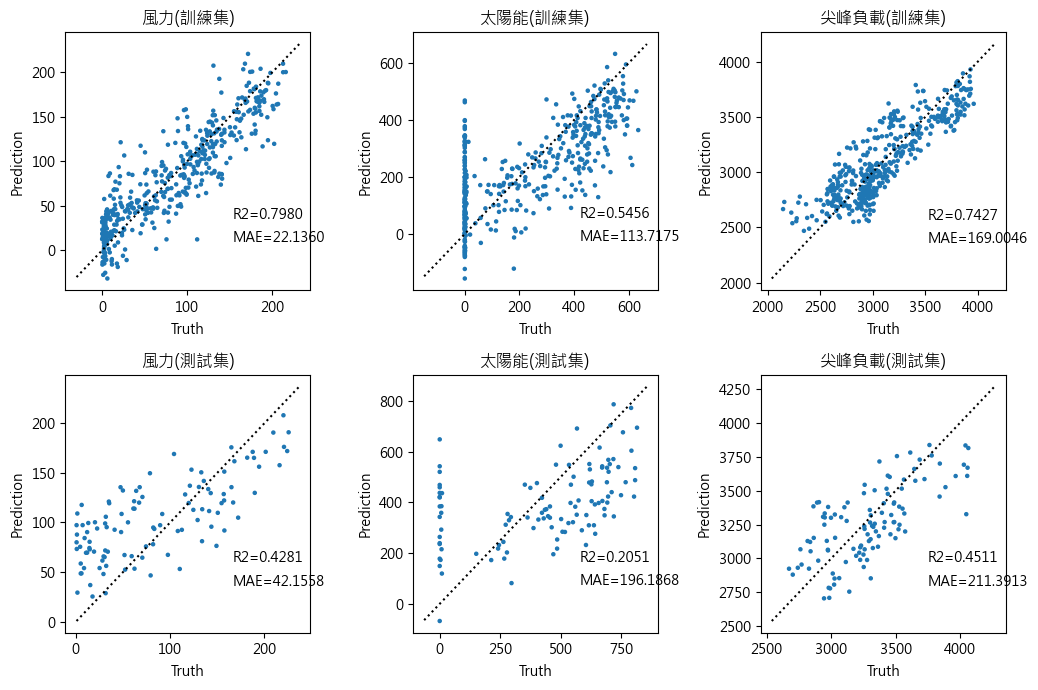

In [40]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches((10.5,7))
train_or_test = ['訓練集', '測試集']
for i in range(2):
    if i == 0:
        grand_X = np.array(Y_train)
        grand_Y = model.predict(X_train)
    elif i == 1:
        grand_X = np.array(Y_test)
        grand_Y = model.predict(X_test)
        mae_list = []
    for j in range(3):
        X = grand_X[:,j]
        Y = grand_Y[:,j]
        this_ax = axes[i][j]
        title = f'{Y_cols[j]}({train_or_test[i]})'
        mae = plot_one_scatter(X, Y, this_ax, title)
        if i == 1:           
            mae_list.append(mae)
fig.tight_layout()

In [41]:
for i, y_col in enumerate(Y_cols):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'Linear Regression', mae_list[i], 'baseline']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline


# 特徵選取與特徵工程

In [42]:
def ModelFit(weather_power_df, X_cols, Y_cols, train_size=train_size, forced_non_negative=False, model = LinearRegression()):
    Xs = weather_power_df[X_cols]
    Ys = weather_power_df[Y_cols]
    
    X_train = np.array(Xs)[0:train_size,:]
    Y_train = np.array(Ys)[0:train_size,:]
    X_test = np.array(Xs)[train_size::,:]
    Y_test = np.array(Ys)[train_size::,:]

    if len(Y_cols) == 1:
        Y_train = Y_train.reshape(-1)
        Y_test = Y_test.reshape(-1)

    if len(Y_cols) == 1:
        Y_train = Y_train.reshape(-1)
        Y_test = Y_test.reshape(-1)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)

    indicator = 'MAE of '
    for col in Y_cols:
        indicator += f'{col}, '
    indicator = indicator[0:-2] + 'are:'
    print('訓練集')
    print(indicator)
    print(MAE(Y_train, Y_pred))
    
    Y_pred = model.predict(X_test)
    print('測試集')
    print(indicator)
    print(MAE(Y_test, Y_pred))
    out_model = deepcopy(model)
    
    fig, axes = plt.subplots(2, len(Y_cols))
    fig.set_size_inches((3.5*len(Y_cols),7))
    train_or_test = ['訓練集', '測試集']
    for i in range(2):
        if i == 0:
            grand_X = np.array(Y_train).reshape(-1, len(Y_cols))
            grand_Y = model.predict(X_train).reshape(-1, len(Y_cols))
        elif i == 1:
            grand_X = np.array(Y_test).reshape(-1, len(Y_cols))
            grand_Y = model.predict(X_test).reshape(-1, len(Y_cols))
            mae_list = []
        for j in range(len(Y_cols)):
            X = grand_X[:,j]
            Y = grand_Y[:,j]

            if len(Y_cols) > 1:
                this_ax = axes[i][j]
            else:
                this_ax = axes[i]
            title = f'{Y_cols[j]}({train_or_test[i]})'
            mae = plot_one_scatter(X, Y, this_ax, title)
            if i == 1:           
                mae_list.append(mae)
    fig.tight_layout()
    return out_model, scaler, mae_list

先刪除比較難以從預報得知的相對濕度，陣風，降水量與降水時數，以及跟全天日照量重疊性較高的日照時數與日照率

In [43]:
X_cols = []
Y_cols = ['風力', '太陽能', '尖峰負載']
X_col_exclude = ['降水量', '降水時數', '相對溼度', '日照時數', '日照率', '最大瞬間風', '東西陣風', '南北陣風', '總雲量', '東西風', '南北風']
for col in weather_power_df.columns:
    if not ((col in power_types.power_generation_big_type.keys() or col in Y_cols + ['日期']) or col.split('_')[0] in X_col_exclude):
        X_cols.append(col)

In [44]:
X_cols

['氣溫_臺北',
 '最高氣溫_臺北',
 '最低氣溫_臺北',
 '風速_臺北',
 '全天空日射量_臺北',
 '氣溫_高雄',
 '最高氣溫_高雄',
 '最低氣溫_高雄',
 '風速_高雄',
 '全天空日射量_高雄',
 '氣溫_嘉義',
 '最高氣溫_嘉義',
 '最低氣溫_嘉義',
 '風速_嘉義',
 '全天空日射量_嘉義',
 '氣溫_東吉島',
 '最高氣溫_東吉島',
 '最低氣溫_東吉島',
 '風速_東吉島',
 '全天空日射量_東吉島',
 '氣溫_臺中電廠',
 '最高氣溫_臺中電廠',
 '最低氣溫_臺中電廠',
 '風速_臺中電廠',
 '日期數字']

訓練集
MAE of 風力, 太陽能, 尖峰負載are:
[ 25.93455207 123.05832547 182.5647397 ]
測試集
MAE of 風力, 太陽能, 尖峰負載are:
[ 42.69507608 208.10895697 230.74704441]


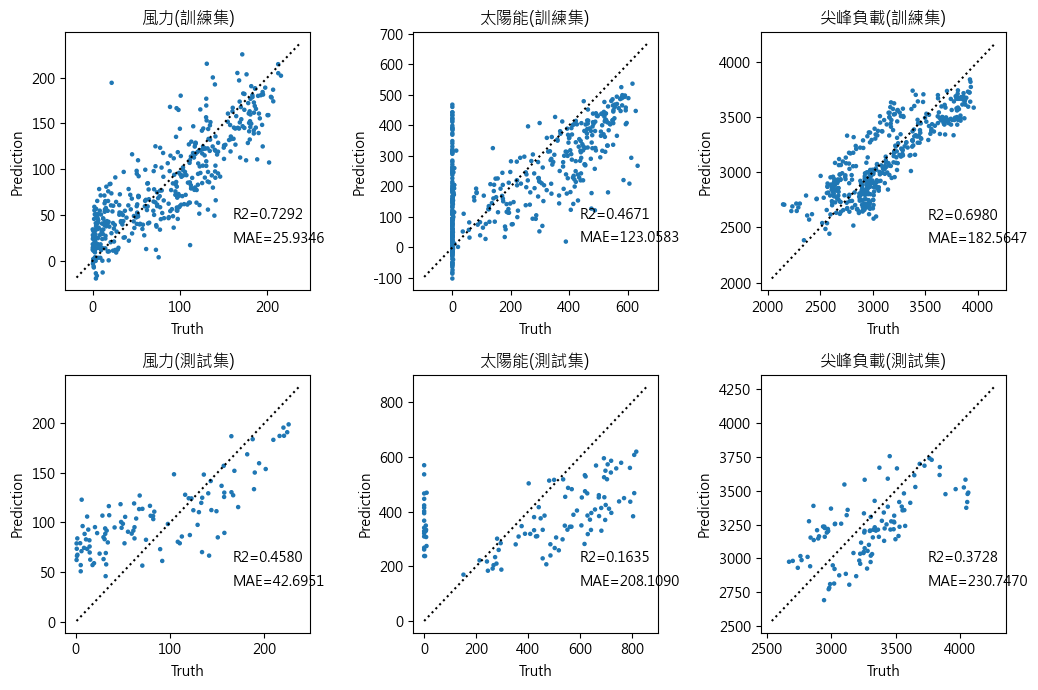

In [45]:
model, scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols)

In [46]:
for i, y_col in enumerate(Y_cols):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'Linear Regression', mae_list[i], '移除數個觀測量']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量


將假日與工作日加進來

In [47]:
weather_power_df['假日'] = [1 if d in holidays else 0 for d in weather_power_df['日期']]
weather_power_df['週六'] = [1 if d.weekday() == 5 else 0 for d in weather_power_df['日期']]
weather_power_df['週日'] = [1 if d.weekday() == 6 else 0 for d in weather_power_df['日期']]
weather_power_df['補班'] = [1 if d in adjusted_work_days else 0 for d in weather_power_df['日期']]

X_cols += ['假日', '週六', '週日', '補班']

訓練集
MAE of 風力, 太陽能, 尖峰負載are:
[25.79500286 91.6406512  93.3238638 ]
測試集
MAE of 風力, 太陽能, 尖峰負載are:
[ 42.25600006 144.10869492  95.9680031 ]


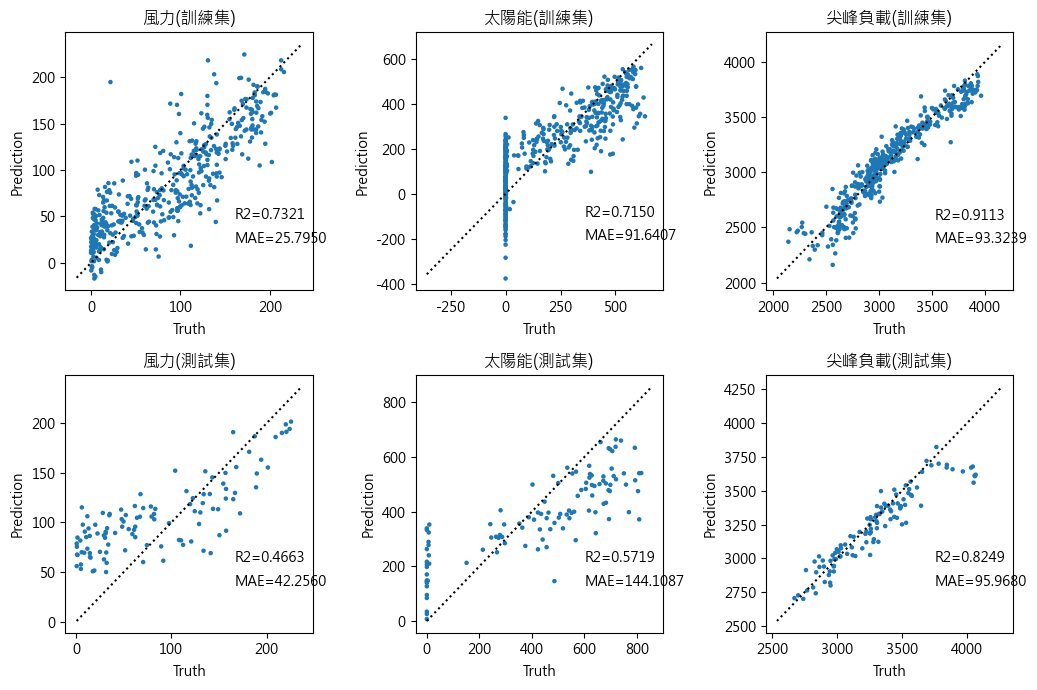

In [48]:
model, scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols)

In [49]:
for i, y_col in enumerate(Y_cols):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'Linear Regression', mae_list[i], '考慮節假日']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量
6,風力,Linear Regression,42.256000,考慮節假日
7,太陽能,Linear Regression,144.108695,考慮節假日
8,尖峰負載,Linear Regression,95.968003,考慮節假日


將季節因素加進來

In [50]:
weather_power_df['1~3月'] = [1 if d.month in [1, 2, 3] and np.sum(weather_power_df[['假日', '週六', '週日']].iloc[i]) == 0 else 0\
                            for i, d in enumerate(weather_power_df['日期'])]
weather_power_df['11~12月'] = [1 if d.month in [11, 12] and np.sum(weather_power_df[['假日', '週六', '週日']].iloc[i]) == 0 else 0\
                              for i, d in enumerate(weather_power_df['日期'])]

X_cols += ['1~3月', '11~12月']

訓練集
MAE of 風力, 太陽能, 尖峰負載are:
[25.71806889 84.14017511 89.34393797]
測試集
MAE of 風力, 太陽能, 尖峰負載are:
[ 41.89357312 135.02037134  88.7505467 ]


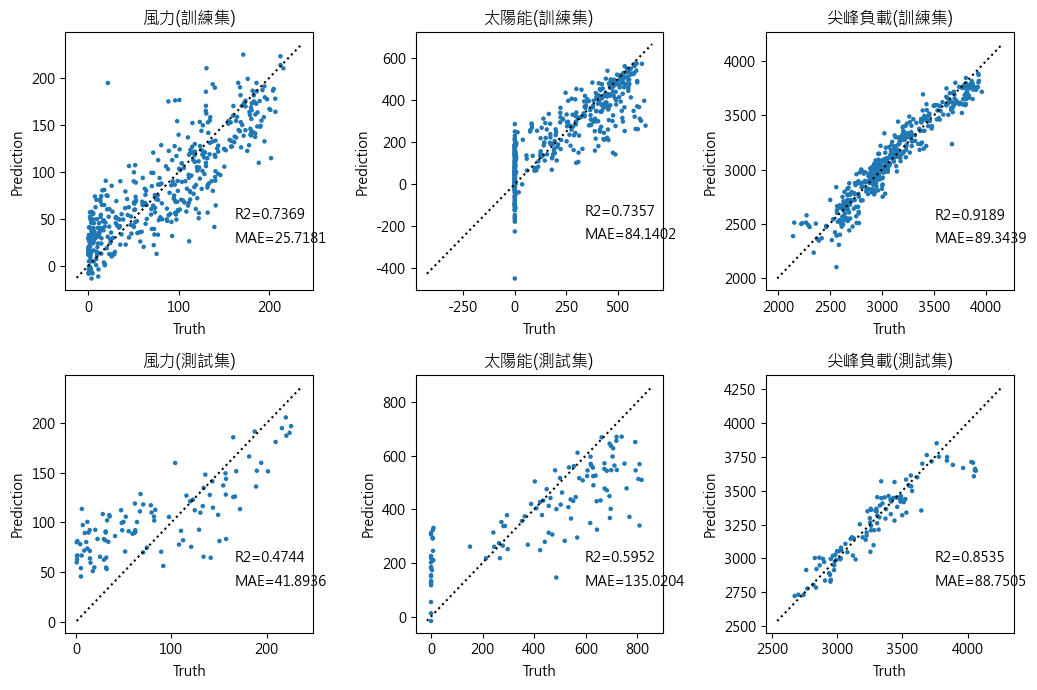

In [51]:
LinearRegressionModel, scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols)

In [52]:
for i, y_col in enumerate(Y_cols):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'Linear Regression', mae_list[i], '考慮季節']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量
6,風力,Linear Regression,42.256000,考慮節假日
7,太陽能,Linear Regression,144.108695,考慮節假日
8,尖峰負載,Linear Regression,95.968003,考慮節假日
9,風力,Linear Regression,41.893573,考慮季節


歸納得知：
1. 刪除較難由氣象署預報預測的降水量與降水時數對模型準確度有微幅負面影響
2. 加入假日與工作日的變量，對太陽能與尖峰負載的準確度有重大正面影響
3. 加入季節因素的影響較不明顯

# 其他模型

## XGBoost

訓練集
MAE of 風力, 太陽能, 尖峰負載are:
[0.0006245  0.00068985 0.00059812]
測試集
MAE of 風力, 太陽能, 尖峰負載are:
[ 29.90067252 183.54737845 122.59545588]


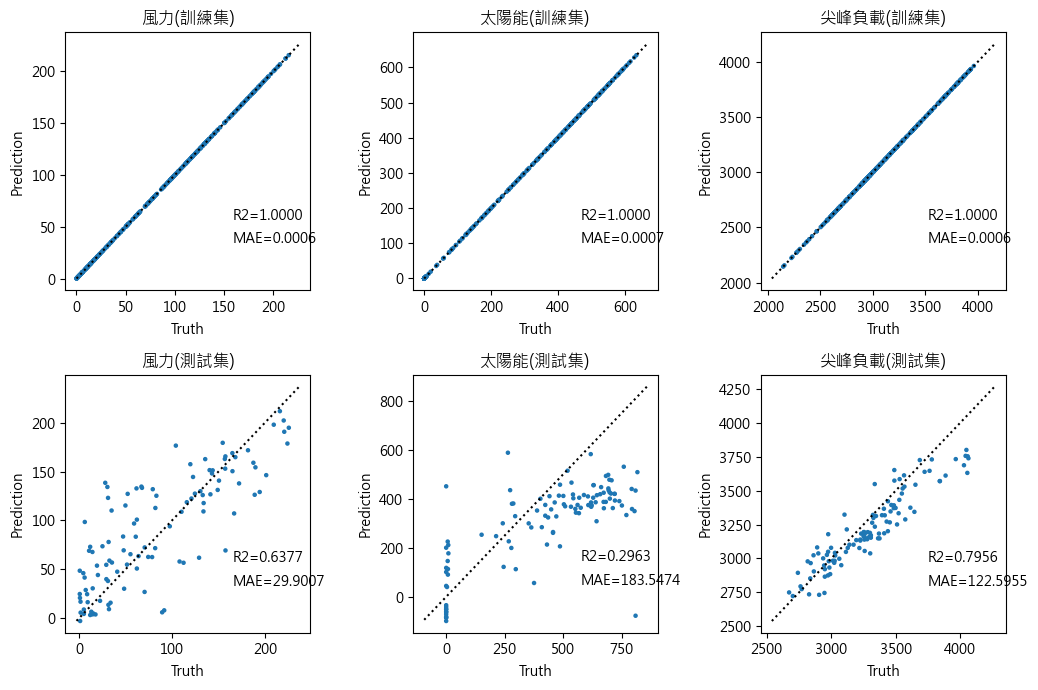

In [53]:
from xgboost import XGBRegressor
XGBModel, scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols, model=XGBRegressor(n_estimators=300))

In [54]:
for i, y_col in enumerate(Y_cols):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'XGBoost', mae_list[i], '']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量
6,風力,Linear Regression,42.256000,考慮節假日
7,太陽能,Linear Regression,144.108695,考慮節假日
8,尖峰負載,Linear Regression,95.968003,考慮節假日
9,風力,Linear Regression,41.893573,考慮季節


## LightGBM

In [55]:
from lightgbm import LGBMRegressor

In [56]:
LGBModels = {}

訓練集
MAE of 風力are:
4.937832735614234
測試集
MAE of 風力are:
28.27577541125604


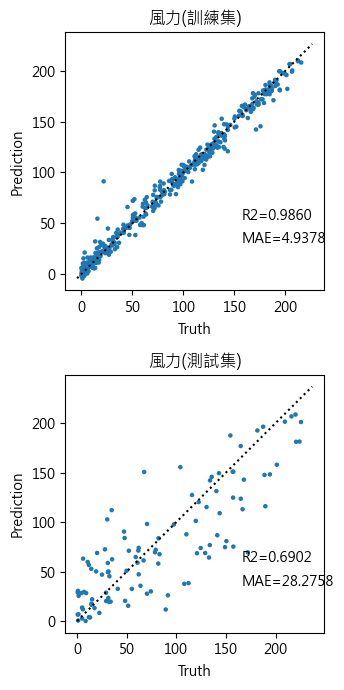

In [57]:
LGBModels['風力'], scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols=['風力'], model=LGBMRegressor(force_col_wise=True, verbose=-1))

In [58]:
for i, y_col in enumerate(['風力']):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'LightGBM', mae_list[i], '']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量
6,風力,Linear Regression,42.256000,考慮節假日
7,太陽能,Linear Regression,144.108695,考慮節假日
8,尖峰負載,Linear Regression,95.968003,考慮節假日
9,風力,Linear Regression,41.893573,考慮季節


訓練集
MAE of 太陽能are:
19.279608081639818
測試集
MAE of 太陽能are:
144.49544613277223


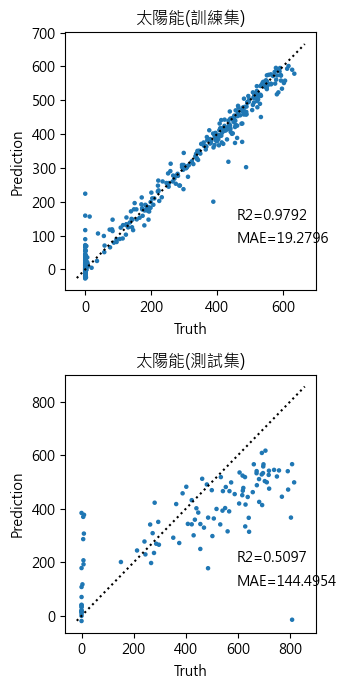

In [59]:
LGBModels['太陽能'], scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols=['太陽能'], model=LGBMRegressor(force_col_wise=True, verbose=-1))

In [60]:
for i, y_col in enumerate(['太陽能']):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'LightGBM', mae_list[i], '']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量
6,風力,Linear Regression,42.256000,考慮節假日
7,太陽能,Linear Regression,144.108695,考慮節假日
8,尖峰負載,Linear Regression,95.968003,考慮節假日
9,風力,Linear Regression,41.893573,考慮季節


訓練集
MAE of 尖峰負載are:
20.896769898634453
測試集
MAE of 尖峰負載are:
105.16192433946819


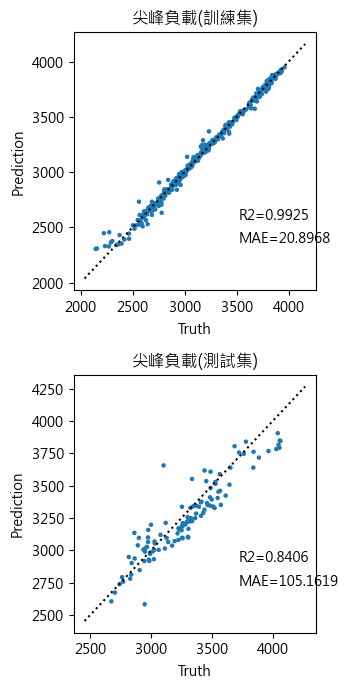

In [61]:
LGBModels['尖峰負載'], scaler, mae_list = ModelFit(weather_power_df, X_cols, Y_cols=['尖峰負載'], model=LGBMRegressor(force_col_wise=True, verbose=-1))

In [62]:
for i, y_col in enumerate(['尖峰負載']):
    mae_record_df.loc[len(mae_record_df)] = [y_col, 'LightGBM', mae_list[i], '']
mae_record_df

,預測對象,Model,MAE,Note
0,風力,Linear Regression,42.155831,baseline
1,太陽能,Linear Regression,196.186783,baseline
2,尖峰負載,Linear Regression,211.391319,baseline
3,風力,Linear Regression,42.695076,移除數個觀測量
4,太陽能,Linear Regression,208.108957,移除數個觀測量
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量
6,風力,Linear Regression,42.256000,考慮節假日
7,太陽能,Linear Regression,144.108695,考慮節假日
8,尖峰負載,Linear Regression,95.968003,考慮節假日
9,風力,Linear Regression,41.893573,考慮季節


## FCN架構類神經網路

In [63]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim

In [64]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print(device.type)

cuda


### 模型定義

In [65]:
class SimpleNN(nn.Module):
    def __init__(self, input_f, output_f, feature_counts, dropout_factor=0):
        super(SimpleNN, self).__init__()
        self.feature_counts = feature_counts
        self.dropout_factor = dropout_factor
        self.BN0 = nn.BatchNorm1d(input_f)
        self.blocks = nn.ModuleList()
        for i, f in enumerate(feature_counts):
            out_f = f
            if i == 0:
                in_f = input_f
            else:
                in_f = feature_counts[i-1]
            self.blocks.append(self.fnn_block(in_f, out_f))
        self.output_layer_A = nn.Linear(feature_counts[-1], output_f)
        self.output_layer_B = nn.Linear(output_f, output_f)
        self.sigmoid = nn.Sigmoid()
    
    
    def fnn_block(self, in_f, out_f, dropout=True, activation=True):
        layers = []
        layers.append(nn.Linear(in_f, out_f))
        layers.append(nn.BatchNorm1d(out_f))
        if activation:
            layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=self.dropout_factor))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.BN0(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_layer_A(x)
        output = self.output_layer_B(x)
        return output

### 訓練用API

In [66]:
class Best_Parameter_Saver():
    def __init__(self, mode, mv_length=10):
        self.mode = mode
        if mode in ['min', 'avg_min']:
            self.best_indicator = 1e20
        elif mode in ['max', 'avg_max']:
            self.best_indicator = -1e20
        self.indicators = []
        self.best_epoch = 0
        self.mv_length = mv_length
            
    def save_params(self, model):
        self.best_model_wts = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        self.best_epoch = len(self.indicators) - 1

    def load_params(self, model):
        model.load_state_dict(self.best_model_wts)
        return model
        
    def update(self, model, indicator):
        self.indicators.append(indicator)
        if self.mode == 'min':
            if indicator < self.best_indicator:
                self.best_indicator = indicator
                self.save_params(model)
        elif self.mode == 'max':
            if indicator > self.best_indicator:
                self.best_indicator = indicator
                self.save_params(model)
        elif 'avg' in self.mode:
            if len(self.indicators) >= self.mv_length:
                moving_avg = np.mean(self.indicators[-self.mv_length::])
                if self.mode == 'avg_min':
                    if moving_avg < self.best_indicator:
                        self.best_indicator = moving_avg
                        self.save_params(model)
                elif self.mode == 'avg_max':
                    if moving_avg > self.best_indicator:
                        self.best_indicator = moving_avg
                        self.save_params(model)

In [67]:
class SimpleNN_with_API():
    # 這個 class 的輸出入資料形式都是 numpy array，class 會自動將輸入資料轉換成 pytorch tensor
    # =====================================================================================
    # 有動用到的 module 與 class 如下
    # import numpy as np
    # from tqdm import tqdm
    # import os
    # import joblib
    # import json
    # import torch
    # import torch.nn as nn
    # from torch.utils.data import DataLoader, TensorDataset
    # import torch.optim as optim
    # from sklearn.preprocessing import StandardScaler
    # SimpleNN
    # Best_Parameter_Saver
    # ======================================================================================
    
    def __init__(self, input_f, output_f, feature_counts, dropout_factor=0, linear_transform=True):
        self.input_f = input_f
        self.output_f = output_f
        self.feature_counts = feature_counts
        self.dropout_factor = dropout_factor

        self.model = SimpleNN(input_f=self.input_f,
                              output_f=self.output_f,
                              feature_counts=self.feature_counts,
                              dropout_factor=self.dropout_factor)
        self.linear_transform = linear_transform
    
    def standard_scaler_fit(self, X, Y):
        self.scalerX = StandardScaler().fit(X)
        self.scalerY = StandardScaler().fit(Y)

        
    def data_preprocess(self, X, Y, batch_size, shuffle):
        X = torch.tensor(self.scalerX.transform(X), dtype=torch.float32)
        Y = torch.tensor(self.scalerY.transform(Y), dtype=torch.float32)
        dataset = TensorDataset(X.to(device), Y.to(device))
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return data_loader

    # 訓練模型
    def fit(self, X_train, Y_train, X_val=None, Y_val=None,
            loss_function=nn.MSELoss(),
            batch_size=16,
            n_epoch=1000,
            L2_factor=0,
            first_lr=1e-3,
            verbose=0):

        self.best_parameter_saver = Best_Parameter_Saver(mode='avg_min', mv_length=10)
        validation = True
        if X_val is None or Y_val is None:
            validation = False
        
        self.standard_scaler_fit(X_train, Y_train)
        train_loader = self.data_preprocess(X_train, Y_train, batch_size, shuffle=True)
        if validation:
            val_loader = self.data_preprocess(X_val, Y_val, batch_size, shuffle=False)

        optimizer = optim.Adam(self.model.parameters(), lr=first_lr, weight_decay=L2_factor)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=10**(-0.5), patience=20)
        criterion = loss_function
        if validation:
            history = {'Train_loss':[], 'Val_loss':[], 'Train_MAE':[], 'Val_MAE':[]}
        else:
            history = {'Train_loss':[], 'Train_MAE':[]}

        previous_lr = first_lr
        self.model.to(device)

        if verbose == 0:
            iterator = tqdm(range(n_epoch))
        else:
            iterator = range(n_epoch)
        for epoch in iterator:
            self.model.train()
            total_train_loss, total_mae, total_samples = 0, 0, 0
            for this_X, this_Y in train_loader:
                optimizer.zero_grad()
                y_pred = self.model(this_X)
                loss_train = criterion(y_pred, this_Y)
                loss_train.backward()
                optimizer.step()
            
                this_batch_size = this_X.size(0)
                total_train_loss += loss_train * this_batch_size
                total_mae += (y_pred - this_Y).abs().mean() * this_batch_size
                total_samples += this_batch_size
            
            mean_loss_train = (total_train_loss / total_samples).item()
            history['Train_loss'].append(mean_loss_train)
            mean_mae_train = (total_mae / total_samples).item()
            history['Train_MAE'].append(mean_mae_train)
            self.history = history

            if validation:
                self.model.eval()
                total_val_loss, total_mae, total_samples = 0, 0, 0
                for this_X, this_Y in val_loader:
                    with torch.no_grad():
                        y_pred = self.model(this_X)
                    loss_val = criterion(y_pred, this_Y)
                    
                    this_batch_size = this_X.size(0)
                    total_val_loss += loss_val * this_batch_size
                    total_mae += (y_pred - this_Y).abs().mean() * this_batch_size
                    total_samples += this_batch_size
                
                mean_loss_val = (total_val_loss / total_samples).item()
                history['Val_loss'].append(mean_loss_val)
                mean_mae_val = (total_mae / total_samples).item()
                history['Val_MAE'].append(mean_mae_val)
                self.history = history
                
                scheduler.step(mean_mae_val)
                self.best_parameter_saver.update(self.model, mean_mae_val)
            else:
                scheduler.step(mean_mae_train)
                self.best_parameter_saver.update(self.model, mean_mae_train)
            
            if verbose==1:
                info_string = f'Epoch: {epoch}, '
                for key, value in history.items():
                    info_string += f'{key}: {value[-1]:.4f}, '
                print(info_string)
                
            current_lr = optimizer.param_groups[0]['lr']
            if not current_lr == previous_lr:
                if current_lr < 1e-6:
                    if verbose == 1:
                        print(f'Learning rate is very small, terimnate training.')
                    break
                if verbose == 1:
                    print(f"Learning rate changed from {previous_lr} to {current_lr}")
                previous_lr = current_lr
                
        self.model = self.best_parameter_saver.load_params(self.model)
        if self.linear_transform:
            test_X = torch.tensor(self.scalerX.transform(X_train), dtype=torch.float32)
            self.Y_t = Y_train
            self.Y_p = self.scalerY.inverse_transform(self.model.to('cpu')(test_X).detach().numpy())

            self.LinearModel = LinearRegression()
            _ = self.LinearModel.fit(self.Y_p.reshape(-1, 1), self.Y_t.reshape(-1))
            
    # 進行推論
    def predict(self, X, linear_transform=True):
        self.model.eval()
        X = torch.tensor(self.scalerX.transform(X), dtype=torch.float32)
        with torch.no_grad():
            Y = self.scalerY.inverse_transform(self.model.to('cpu')(X).detach().numpy())
        if linear_transform:
            Y = self.LinearModel.predict(Y.reshape(-1,1))
        return Y

    # 儲存模型參數，file_path是一個目錄，如果之前不存在則會自動建立
    def save_weight(self, file_path):
        if not os.path.exists(file_path):
            os.makedirs(file_path, exist_ok=True)
        torch.save(self.model.state_dict(), file_path + 'FCN.pt')
        joblib.dump(self.scalerX, file_path + 'scalerX.model')
        joblib.dump(self.scalerY, file_path + 'scalerY.model')
        if self.linear_transform:
            joblib.dump(self.LinearModel, file_path + 'LinearModel.model')

        model_params_dict = {
            'input_f': self.input_f,
            'output_f': self.output_f,
            'feature_counts': self.feature_counts,
            'dropout_factor': self.dropout_factor,
            'linear_transform': self.linear_transform
        }
        with open(file_path + 'hyper_parameters.json', 'w') as f:
            _ = json.dump(model_params_dict, f)

    # 讀取模型參數，file_path是前面 self.save_weight 產生的那個目錄
    def load_weight(self, file_path):
        self.model.load_state_dict(torch.load(file_path + 'FCN.pt'))
        self.scalerX = joblib.load(file_path + 'scalerX.model')
        self.scalerY = joblib.load(file_path + 'scalerY.model')
        if self.linear_transform:
            self.LinearModel = joblib.load(file_path + 'LinearModel.model')

In [68]:
def visualized_model_evaluation(Model, Y_feature, X_train, Y_train, X_val, Y_val, linear_transform=False):
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(7.5, 7.5)

    this_ax = axes[0][0]
    this_ax.plot(Model.history['Train_loss'], label='Train Loss')
    this_ax.plot(Model.history['Val_loss'], label='Validation Loss')
    _ = this_ax.legend()
    _ = this_ax.set_xlabel('Epoch')
    _ = this_ax.set_ylabel('Loss')

    this_ax = axes[0][1]
    this_ax.plot(Model.history['Train_MAE'], label='Train MAE')
    this_ax.plot(Model.history['Val_MAE'], label='Validation MAE')
    _ = this_ax.legend()
    _ = this_ax.set_xlabel('Epoch')
    _ = this_ax.set_ylabel('MAE')

    this_ax = axes[1][0]
    X, Y = X_train, Y_train
    Y_p = Model.predict(X, linear_transform=linear_transform)
    max_XY = max(np.max(Y), np.max(Y_p))
    min_XY = max(np.min(Y), np.min(Y_p))
    mae = np.mean(np.abs(Y.reshape(-1)-Y_p.reshape(-1)))
    
    this_ax.scatter(Y, Y_p, Y * 0 + 6)
    this_ax.plot([min_XY, max_XY], [min_XY, max_XY], ':k')
    _ = this_ax.set_xlabel('Truth')
    _ = this_ax.set_ylabel('Prediction')
    _ = this_ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.7 + max_XY * 0.3, f'MAE={mae:.4f}')
    _ = this_ax.set_title('Training Set')

    this_ax = axes[1][1]
    X, Y = X_val, Y_val
    Y_p = Model.predict(X, linear_transform=linear_transform)
    max_XY = max(np.max(Y), np.max(Y_p))
    min_XY = max(np.min(Y), np.min(Y_p))
    mae = np.mean(np.abs(Y.reshape(-1)-Y_p.reshape(-1)))
    
    this_ax.scatter(Y, Y_p, Y * 0 + 6)
    this_ax.plot([min_XY, max_XY], [min_XY, max_XY], ':k')
    _ = this_ax.set_xlabel('Truth')
    _ = this_ax.set_ylabel('Prediction')
    _ = this_ax.text(min_XY * 0.3 + max_XY * 0.7, min_XY * 0.7 + max_XY * 0.3, f'MAE={mae:.4f}')
    _ = this_ax.set_title('Validation Set')

    fig.suptitle(Y_feature)
    fig.tight_layout()

In [69]:
def model_training_and_evaluation(X_train, Y_train, X_val, Y_val, Y_feature, dropout_factor, L2_factor,
                                  feature_counts = [2048, 1024, 512, 256, 128, 64, 32, 16, 8],
                                  return_model=False, visualization=False, linear_transform=False):

    input_f = X_train.shape[1]
    output_f = Y_train.shape[1]
    Model = SimpleNN_with_API(input_f, output_f, feature_counts, dropout_factor=dropout_factor)

    Model.fit(X_train, Y_train, X_val, Y_val,
          loss_function=nn.MSELoss(),
          batch_size=16, 
          n_epoch=1000, 
          L2_factor=L2_factor,
          first_lr=1e-3,
          verbose=-1)

    if visualization:
        visualized_model_evaluation(Model, Y_cols[0], X_train, Y_train, X_val, Y_val, linear_transform=linear_transform)

    X, Y = X_val, Y_val
    Y_p = Model.predict(X, linear_transform=linear_transform).reshape(-1)
    max_XY = max(np.max(Y), np.max(Y_p))
    min_XY = max(np.min(Y), np.min(Y_p))
    mae = np.mean(np.abs(Y.reshape(-1)-Y_p))

    if return_model:
        return mae, Model
    return mae

### 訓練與評估

In [70]:
FCNModels = {}

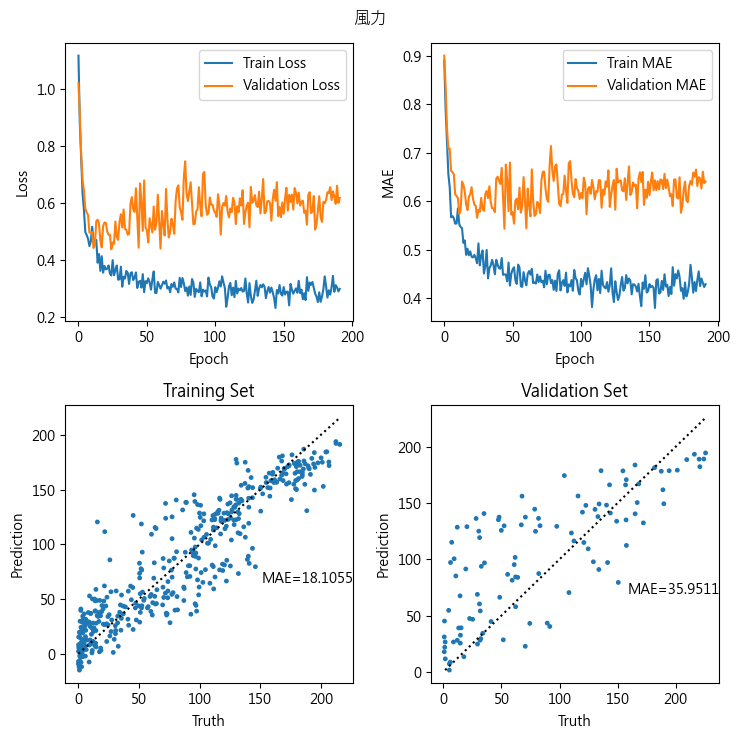

In [71]:
Y_cols = ['風力']
Y_feature = Y_cols[0]
#feature_counts = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8]
feature_counts = [64, 32, 16, 8]
dropout_factor = 0.2
L2_factor = 5e-4

raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df[Y_cols], dtype=np.float32)

train_size = int(raw_Xs.shape[0] * 0.8)
X_train = raw_Xs[0:train_size]
Y_train = raw_Ys[0:train_size]
X_val = raw_Xs[train_size::]
Y_val = raw_Ys[train_size::]

mae, FCNModels[Y_feature] = model_training_and_evaluation(X_train, Y_train, X_val, Y_val, 
                                                          Y_feature, dropout_factor, L2_factor, feature_counts, 
                                                          visualization=True, linear_transform=True, return_model=True)
mae_record_df.loc[len(mae_record_df)] = [Y_feature, 'FCN', mae, f'{feature_counts}, dp: {dropout_factor}, L2: {L2_factor:.2e}']

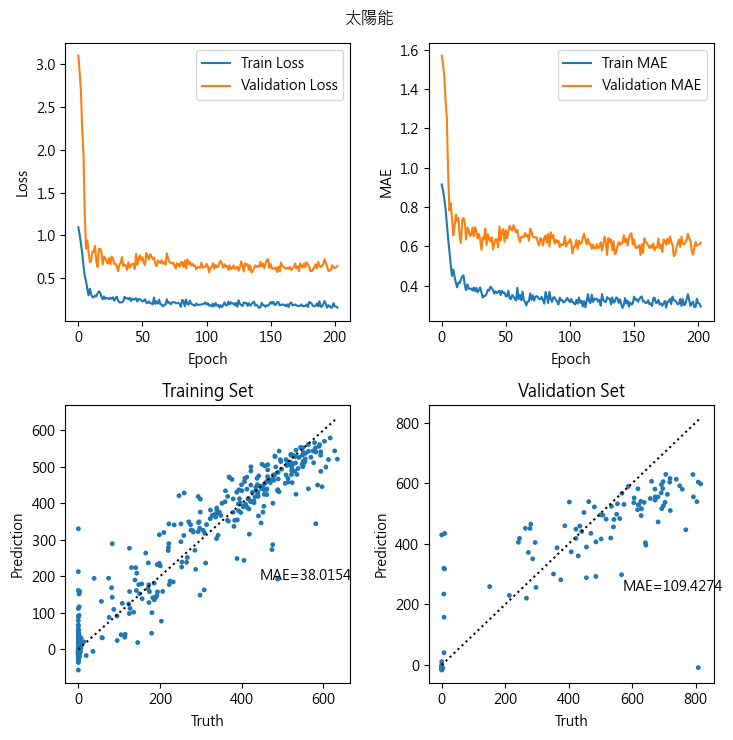

In [72]:
Y_cols = ['太陽能']
Y_feature = Y_cols[0]
feature_counts = [128, 64, 32, 16, 8]
dropout_factor = 0.1
L2_factor = 1e-2

raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df[Y_cols], dtype=np.float32)

input_f = raw_Xs.shape[1]
output_f = raw_Ys.shape[1]

train_size = int(raw_Xs.shape[0] * 0.8)
X_train = raw_Xs[0:train_size]
Y_train = raw_Ys[0:train_size]
X_val = raw_Xs[train_size::]
Y_val = raw_Ys[train_size::]

mae, FCNModels[Y_feature] = model_training_and_evaluation(X_train, Y_train, X_val, Y_val, 
                                                          Y_feature, dropout_factor, L2_factor, feature_counts, 
                                                          visualization=True, linear_transform=True, return_model=True)
mae_record_df.loc[len(mae_record_df)] = [Y_feature, 'FCN', mae, f'{feature_counts}, dp: {dropout_factor}, L2: {L2_factor:.2e}']

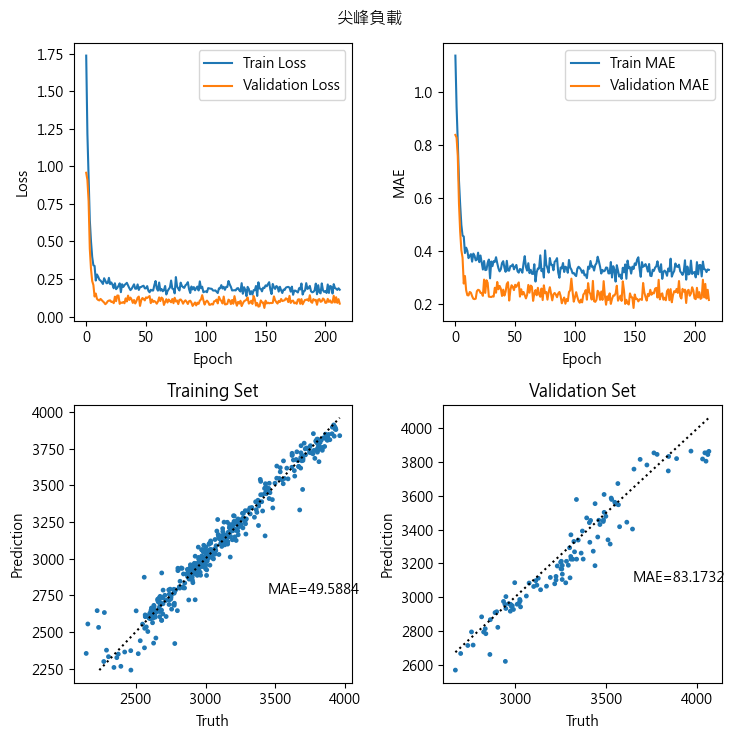

In [73]:
Y_cols = ['尖峰負載']
Y_feature = Y_cols[0]
feature_counts = [64, 32, 16, 8]
dropout_factor = 0.1
L2_factor = 0

raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df[Y_cols], dtype=np.float32)

input_f = raw_Xs.shape[1]
output_f = raw_Ys.shape[1]

train_size = int(raw_Xs.shape[0] * 0.8)
X_train = raw_Xs[0:train_size]
Y_train = raw_Ys[0:train_size]
X_val = raw_Xs[train_size::]
Y_val = raw_Ys[train_size::]

mae, FCNModels[Y_feature] = model_training_and_evaluation(X_train, Y_train, X_val, Y_val, 
                                                          Y_feature, dropout_factor, L2_factor, feature_counts, 
                                                          visualization=True, linear_transform=True, return_model=True)
mae_record_df.loc[len(mae_record_df)] = [Y_feature, 'FCN', mae, f'{feature_counts}, dp: {dropout_factor}, L2: {L2_factor:.2e}']

# 綜合比較

In [74]:
y_feature = '風力'
this_df = mae_record_df[mae_record_df['預測對象'] == y_feature].sort_values('MAE')
this_df

,預測對象,Model,MAE,Note
15,風力,LightGBM,28.275775,
12,風力,XGBoost,29.900673,
18,風力,FCN,35.951141,"[64, 32, 16, 8], dp: 0.2, L2: 5.00e-04"
9,風力,Linear Regression,41.893573,考慮季節
0,風力,Linear Regression,42.155831,baseline
6,風力,Linear Regression,42.256000,考慮節假日
3,風力,Linear Regression,42.695076,移除數個觀測量


In [75]:
y_feature = '太陽能'
this_df = mae_record_df[mae_record_df['預測對象'] == y_feature].sort_values('MAE')
this_df

,預測對象,Model,MAE,Note
19,太陽能,FCN,109.427422,"[128, 64, 32, 16, 8], dp: 0.1, L2: 1.00e-02"
10,太陽能,Linear Regression,135.020371,考慮季節
7,太陽能,Linear Regression,144.108695,考慮節假日
16,太陽能,LightGBM,144.495446,
13,太陽能,XGBoost,183.547378,
1,太陽能,Linear Regression,196.186783,baseline
4,太陽能,Linear Regression,208.108957,移除數個觀測量


In [76]:
y_feature = '尖峰負載'
this_df = mae_record_df[mae_record_df['預測對象'] == y_feature].sort_values('MAE')
this_df

,預測對象,Model,MAE,Note
20,尖峰負載,FCN,83.173210,"[64, 32, 16, 8], dp: 0.1, L2: 0.00e+00"
11,尖峰負載,Linear Regression,88.750547,考慮季節
8,尖峰負載,Linear Regression,95.968003,考慮節假日
17,尖峰負載,LightGBM,105.161924,
14,尖峰負載,XGBoost,122.595456,
2,尖峰負載,Linear Regression,211.391319,baseline
5,尖峰負載,Linear Regression,230.747044,移除數個觀測量


# Ensemble

原則上選取每個特徵的前三名模型，分別進行預測之後取平均得到最後結果 <br>
不過由於 fully connected network 的誤差方向常常跟其他模型相反，所以 FCN 一定會被選進平均用的三個模型之一

## 風力

In [77]:
Y_cols = ['風力', '太陽能', '尖峰負載']
Ensemble_model_lists = {col: [] for col in Y_cols}
Ensemble_model_lists['Scaler'] = scaler

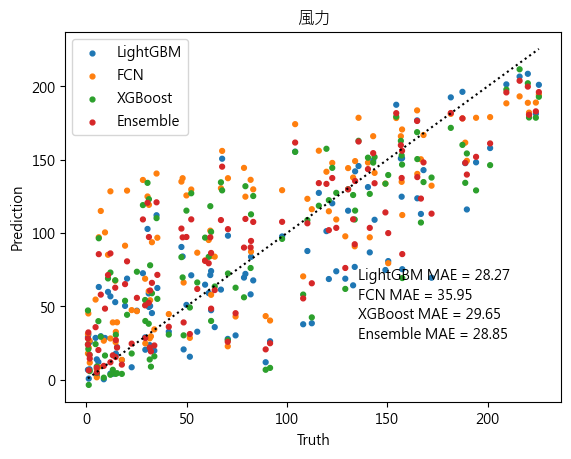

In [78]:
Y_feature = '風力'
model_labels = ['LightGBM', 'FCN', 'XGBoost']

raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df[[Y_feature]], dtype=np.float32)

train_size = int(raw_Xs.shape[0] * 0.8)
X_val = raw_Xs[train_size::]
Y_val = raw_Ys[train_size::]

Y_preds = []
for model_label in model_labels:
    if model_label == 'Linear Regression':
        this_model = LinearRegressionModel
    elif model_label == 'XGBoost':
        this_model = XGBModel
    elif model_label == 'LightGBM':
        this_model = LGBModels[Y_feature]
    elif model_label == 'FCN':
        this_model = FCNModels[Y_feature]

    if model_label == 'FCN':
        this_pred = this_model.predict(X_val)
    else:
        this_pred = this_model.predict(scaler.transform(X_val))
        
    if this_pred.shape[-1] == 3:
        this_pred = this_pred[:, Y_cols.index(Y_feature)].reshape(-1)
    else:
        this_pred = this_pred.reshape(-1)
    Y_preds.append(this_pred)
    Ensemble_model_lists[Y_feature].append(this_model)

Y_p = np.mean(np.array(Y_preds), axis=0)
max_XY = max(np.max(Y_val), np.max(Y_p))
min_XY = min(np.min(Y_val), np.min(Y_p))
mae = np.mean(np.abs(Y_val.reshape(-1) - Y_p))

for i, model_label in enumerate(model_labels):
    this_mae = np.mean(np.abs(Y_val.reshape(-1) - Y_preds[i]))
    plt.scatter(Y_val, Y_preds[i], Y_val * 0 + 12, label=model_label)
    _ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * (0.7 + i * 0.06) + max_XY * (0.3 - i * 0.06), f'{model_label} MAE = {this_mae:.2f}')

plt.scatter(Y_val, Y_p, Y_val * 0 + 12, label='Ensemble')
plt.plot([min_XY, max_XY], [min_XY, max_XY], ':k')
_ = plt.legend()
_ = plt.xlabel('Truth')
_ = plt.ylabel('Prediction')
_ = plt.title(Y_feature)
_ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * 0.88 + max_XY * 0.12, f'Ensemble MAE = {mae:.2f}')

mae_record_df.loc[len(mae_record_df)] = [Y_feature, 'Ensemble', mae, '']

## 太陽能

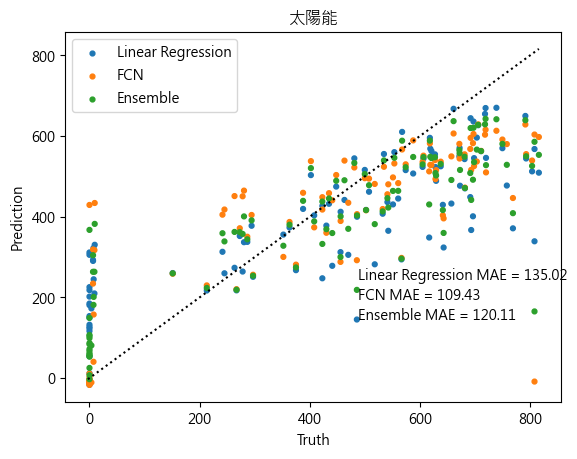

In [79]:
Y_feature = '太陽能'
#model_labels = ['Linear Regression', 'FCN', 'LightGBM']
model_labels = ['Linear Regression', 'FCN']

raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df[[Y_feature]], dtype=np.float32)

train_size = int(raw_Xs.shape[0] * 0.8)
X_val = raw_Xs[train_size::]
Y_val = raw_Ys[train_size::]

Y_preds = []
for model_label in model_labels:
    if model_label == 'Linear Regression':
        this_model = LinearRegressionModel
    elif model_label == 'XGBoost':
        this_model = XGBModel
    elif model_label == 'LightGBM':
        this_model = LGBModels[Y_feature]
    elif model_label == 'FCN':
        this_model = FCNModels[Y_feature]

    if model_label == 'FCN':
        this_pred = this_model.predict(X_val)
    else:
        this_pred = this_model.predict(scaler.transform(X_val))
        
    if this_pred.shape[-1] == 3:
        this_pred = this_pred[:, Y_cols.index(Y_feature)].reshape(-1)
    else:
        this_pred = this_pred.reshape(-1)
    Y_preds.append(this_pred)
    Ensemble_model_lists[Y_feature].append(this_model)

Y_p = np.mean(np.array(Y_preds), axis=0)
max_XY = max(np.max(Y_val), np.max(Y_p))
min_XY = min(np.min(Y_val), np.min(Y_p))
mae = np.mean(np.abs(Y_val.reshape(-1) - Y_p))

for i, model_label in enumerate(model_labels):
    this_mae = np.mean(np.abs(Y_val.reshape(-1) - Y_preds[i]))
    plt.scatter(Y_val, Y_preds[i], Y_val * 0 + 12, label=model_label)
    _ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * (0.7 + i * 0.06) + max_XY * (0.3 - i * 0.06), f'{model_label} MAE = {this_mae:.2f}')

plt.scatter(Y_val, Y_p, Y_val * 0 + 12, label='Ensemble')
plt.plot([min_XY, max_XY], [min_XY, max_XY], ':k')
_ = plt.legend()
_ = plt.xlabel('Truth')
_ = plt.ylabel('Prediction')
_ = plt.title(Y_feature)
_ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * (0.7 + len(model_labels) * 0.06) + max_XY * (0.3 - len(model_labels) * 0.06), f'Ensemble MAE = {mae:.2f}')

mae_record_df.loc[len(mae_record_df)] = [Y_feature, 'Ensemble', mae, '']

## 尖峰負載

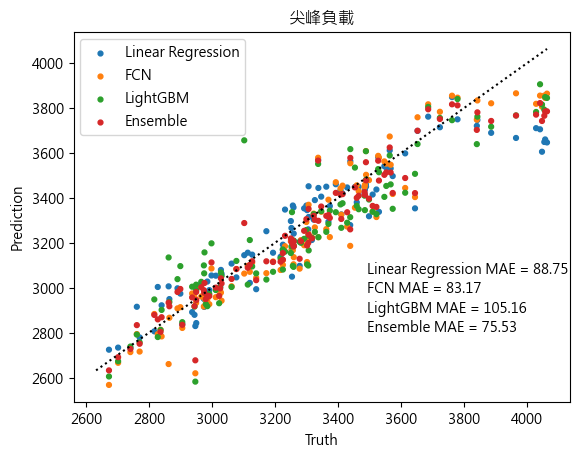

In [80]:
Y_feature = '尖峰負載'
model_labels = ['Linear Regression', 'FCN', 'LightGBM']

raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df[[Y_feature]], dtype=np.float32)

train_size = int(raw_Xs.shape[0] * 0.8)
X_val = raw_Xs[train_size::]
Y_val = raw_Ys[train_size::]

Y_preds = []
for model_label in model_labels:
    if model_label == 'Linear Regression':
        this_model = LinearRegressionModel
    elif model_label == 'XGBoost':
        this_model = XGBModel
    elif model_label == 'LightGBM':
        this_model = LGBModels[Y_feature]
    elif model_label == 'FCN':
        this_model = FCNModels[Y_feature]

    if model_label == 'FCN':
        this_pred = this_model.predict(X_val)
    else:
        this_pred = this_model.predict(scaler.transform(X_val))
        
    if this_pred.shape[-1] == 3:
        this_pred = this_pred[:, Y_cols.index(Y_feature)].reshape(-1)
    else:
        this_pred = this_pred.reshape(-1)
    Y_preds.append(this_pred)
    Ensemble_model_lists[Y_feature].append(this_model)

Y_p = np.mean(np.array(Y_preds), axis=0)
max_XY = max(np.max(Y_val), np.max(Y_p))
min_XY = min(np.min(Y_val), np.min(Y_p))
mae = np.mean(np.abs(Y_val.reshape(-1) - Y_p))

for i, model_label in enumerate(model_labels):
    this_mae = np.mean(np.abs(Y_val.reshape(-1) - Y_preds[i]))
    plt.scatter(Y_val, Y_preds[i], Y_val * 0 + 12, label=model_label)
    _ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * (0.7 + i * 0.06) + max_XY * (0.3 - i * 0.06), f'{model_label} MAE = {this_mae:.2f}')

plt.scatter(Y_val, Y_p, Y_val * 0 + 12, label='Ensemble')
plt.plot([min_XY, max_XY], [min_XY, max_XY], ':k')
_ = plt.legend()
_ = plt.xlabel('Truth')
_ = plt.ylabel('Prediction')
_ = plt.title(Y_feature)
_ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * 0.88 + max_XY * 0.12, f'Ensemble MAE = {mae:.2f}')

mae_record_df.loc[len(mae_record_df)] = [Y_feature, 'Ensemble', mae, '']

## MAE 比較

目前看到在預測風力發電與尖峰負載的場景，Ensemble拿到了最好的 MAE，預測太陽能時 Fully Connected Network 單獨使用的效果較好。

In [81]:
y_feature = '風力'
this_df = mae_record_df[mae_record_df['預測對象'] == y_feature].sort_values('MAE').reset_index(drop=True)
this_df

,預測對象,Model,MAE,Note
0,風力,LightGBM,28.275775,
1,風力,Ensemble,28.853075,
2,風力,XGBoost,29.900673,
3,風力,FCN,35.951141,"[64, 32, 16, 8], dp: 0.2, L2: 5.00e-04"
4,風力,Linear Regression,41.893573,考慮季節
5,風力,Linear Regression,42.155831,baseline
6,風力,Linear Regression,42.256000,考慮節假日
7,風力,Linear Regression,42.695076,移除數個觀測量


In [82]:
y_feature = '太陽能'
this_df = mae_record_df[mae_record_df['預測對象'] == y_feature].sort_values('MAE').reset_index(drop=True)
this_df

,預測對象,Model,MAE,Note
0,太陽能,FCN,109.427422,"[128, 64, 32, 16, 8], dp: 0.1, L2: 1.00e-02"
1,太陽能,Ensemble,120.110871,
2,太陽能,Linear Regression,135.020371,考慮季節
3,太陽能,Linear Regression,144.108695,考慮節假日
4,太陽能,LightGBM,144.495446,
5,太陽能,XGBoost,183.547378,
6,太陽能,Linear Regression,196.186783,baseline
7,太陽能,Linear Regression,208.108957,移除數個觀測量


In [83]:
y_feature = '尖峰負載'
this_df = mae_record_df[mae_record_df['預測對象'] == y_feature].sort_values('MAE').reset_index(drop=True)
this_df

,預測對象,Model,MAE,Note
0,尖峰負載,Ensemble,75.532454,
1,尖峰負載,FCN,83.173210,"[64, 32, 16, 8], dp: 0.1, L2: 0.00e+00"
2,尖峰負載,Linear Regression,88.750547,考慮季節
3,尖峰負載,Linear Regression,95.968003,考慮節假日
4,尖峰負載,LightGBM,105.161924,
5,尖峰負載,XGBoost,122.595456,
6,尖峰負載,Linear Regression,211.391319,baseline
7,尖峰負載,Linear Regression,230.747044,移除數個觀測量


## 儲存模型

In [84]:
model_path = './Models_on_historical_data_test/'
os.makedirs(model_path, exist_ok=True)
with open(model_path + 'X_columns.txt', 'w') as f:
    for col in X_cols:
        f.write(col + ', ')

for key in Ensemble_model_lists.keys():
    if key == 'Scaler':
        joblib.dump(Ensemble_model_lists[key], model_path + 'XScaler.pkl')
    else:
        model_list = Ensemble_model_lists[key]
        this_path = model_path + f'{key}/'
        os.makedirs(this_path, exist_ok=True)
        for model in model_list:
            if 'sklearn' in str(type(model)):
                model_type = str(type(model)).split("'")[1].split('.')[-1]
                joblib.dump(model, this_path + model_type + '.pkl')
            else:
                model.save_weight(this_path + 'FCN_model/')

# 太陽能的 Revise

後來我偶然間發現為什麼台電提供的歷史發電資料中，太陽能有時候會降低到0或接近0的原因。 <br>
台電官網的歷史資料是每天的用電尖峰那一刻，每一個機組實際發電的功率， <br>
而台灣全國的總耗電量在一天之內會有兩個尖峰時間：下午 1 到 2 點，被稱為午尖峰，以及晚上 7 點左右，被稱為夜尖峰。 <br>
通常在上班日午尖峰會高於夜尖峰，這時太陽能的功率會很接近一天的最大值，<br>
但是在假日或是天氣比較冷的時候，午尖峰的數值常常會降到比夜尖峰低，<br>
而台電的官網這時就會回報夜尖峰當下各機組的發電量。 <br>
也因此官網上的太陽能發電就會很接近 0 ，因為這時太陽可能快要下山，也可能已經下山。 <br>

因此我想到一個可能可行的方法，就是將太陽能發電量資料以50萬千瓦為分界分成兩組，然後使用分類模型 (諸如隨機森林等) 嘗試預測每一天的資料是否屬於低太陽能的分組， <br>
如果前面的分類成效不錯，那就把被分類為低太陽能的資料的預測太陽能數值設為 0，看看 MAE 會不會比前面的冠軍 FCN 要好。 

In [85]:
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [86]:
raw_Xs = np.array(weather_power_df[X_cols], dtype=np.float32)
raw_Ys = np.array(weather_power_df['太陽能'], dtype=np.float32)
raw_C = [0 if raw_Ys[i] > 50 else 1 for i in range(raw_Ys.shape[0])]

In [87]:
X_train = np.array(raw_Xs)[0:train_size,:]
Y_train = np.array(raw_Ys)[0:train_size,]
X_test = np.array(raw_Xs)[train_size::,:]
Y_test = np.array(raw_Ys)[train_size::,]
C_train = np.array(raw_C)[0:train_size]
C_test = np.array(raw_C)[train_size::]

#X_train, X_test, Y_train, Y_test = train_test_split(np.array(raw_Xs)[:,0:-1], np.array(raw_Y_01), test_size=0.2)
Sol_Energy_Classify_Model = XGBClassifier()
_ = Sol_Energy_Classify_Model.fit(X_train, C_train)
C_pred = Sol_Energy_Classify_Model.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(C_test, C_pred))
print(f'F1-score {f1_score(C_test, C_pred):.4f}')

Confusion Matrix:
[[84  3]
 [ 3 20]]
F1-score 0.8696


In [88]:
Y_preds = []
Y_preds_with_class = []
model_labels = ['Linear Regression', 'FCN']
for model in Ensemble_model_lists['太陽能']:
    if not 'API' in str(type(model)):
        this_pred = model.predict(scaler.transform(X_test))
    else:
        this_pred = model.predict(X_test)

    if this_pred.shape[-1] == 3:
        this_pred = this_pred[:, Y_cols.index('太陽能')].reshape(-1)
    else:
        this_pred = this_pred.reshape(-1)
        
    this_pred_c = this_pred * 1
    this_pred_c[np.where(C_pred==1)] = 0
    Y_preds.append(this_pred)
    Y_preds_with_class.append(this_pred_c)
    
for i, label in enumerate(model_labels):
    print(label)
    print(f'MAE without classification: {MAE(Y_test, Y_preds[i]):.2f}')
    print(f'MAE with classification: {MAE(Y_test, Y_preds_with_class[i]):.2f}')
    print('='*20)

print('Ensemble')
print(f'MAE without classification: {MAE(Y_test, np.mean(Y_preds, axis=0)):.2f}')
print(f'MAE with classification: {MAE(Y_test, np.mean(Y_preds_with_class, axis=0)):.2f}')

Linear Regression
MAE without classification: 135.02
MAE with classification: 110.01
FCN
MAE without classification: 109.43
MAE with classification: 105.81
Ensemble
MAE without classification: 120.11
MAE with classification: 107.25


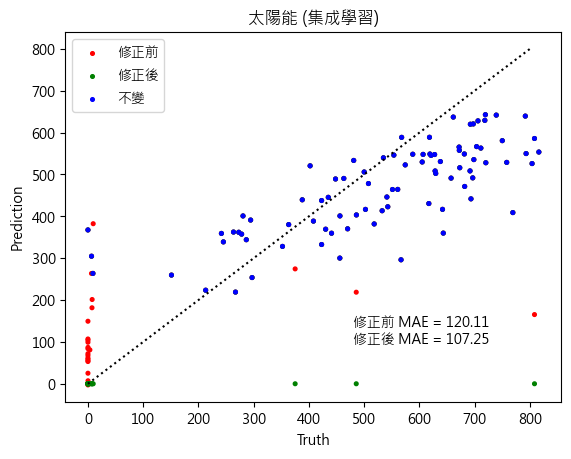

In [89]:
fig, ax = plt.subplots()

min_XY = 0; max_XY = 800
plt.scatter(Y_test, np.mean(Y_preds, axis=0), Y_test * 0 + 7, label='修正前', color = 'red')
plt.scatter(Y_test, np.mean(Y_preds_with_class, axis=0), Y_test * 0 + 7, label='修正後', color = 'green')
plt.scatter(Y_test[np.where(C_pred==0)], np.mean(Y_preds_with_class, axis=0)[np.where(C_pred==0)], Y_test[np.where(C_pred==0)] * 0 + 7, label='不變', color = 'blue')
plt.plot([min_XY, max_XY], [min_XY, max_XY], ':k')
_ = plt.legend()
_ = plt.xlabel('Truth')
_ = plt.ylabel('Prediction')
_ = plt.title('太陽能 (集成學習)')
_ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * 0.83 + max_XY * 0.17, f'修正前 MAE = {MAE(Y_test, np.mean(Y_preds, axis=0)):.2f}')
_ = plt.text(min_XY * 0.4 + max_XY * 0.6, min_XY * 0.88 + max_XY * 0.12, f'修正後 MAE = {MAE(Y_test, np.mean(Y_preds_with_class, axis=0)):.2f}')

修改後的模型確實顯著改善了預測的準確率，也讓新的集成學習的成果超過了原本的fully connected network

In [90]:
_ = joblib.dump(Sol_Energy_Classify_Model, model_path + '太陽能/Sol_Energy_Classify_Model.pkl')